# SCP Toolbox Workshop

___A tutorial on generating dynamically feasible trajectories reliably and efficiently___

Monday, February 7, 2022

Rocky Mountain AAS GN&C Conference, Breckenridge, CO

In [1]:
import Pkg
Pkg.activate("..")

# these lines are required only for local installations
Pkg.develop(path="../../scp_traj_opt/")
Pkg.precompile()

using SCPToolbox
using PyPlot, Colors, LinearAlgebra

# Import the different possible low-level convex solvers
using COSMO
using Ipopt
using SCS
using ECOS
using OSQP

  Activating project at `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial`
   Resolving package versions...
  No Changes to `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial/Project.toml`
  No Changes to `~/Nextcloud/personal/research/scp/aas_gnc_workshop/tutorial/Manifest.toml`
┌ Info: Precompiling SCPToolbox [bd2bc758-a5dc-11eb-050f-6b2434548817]
└ @ Base loading.jl:1423


# Part 3: Dubin's Car Trajectory Optimization

Solve the following trajectory generation problem:

<div style="text-align: center">
    <img src="../media/p3-dubin-car-overview.png"
         alt="Dubin's car overview"
         style="background-color: white; width: 400px; display: block; margin-left: auto; margin-right: auto;"/>
    <b>Figure.</b> Illustration of Dubin's car problem.
</div>

* Begin at an initial state
* Travel to the target state
* Avoid a circular obstacle in the way of a straight path
* Subject to Dubin's car dynamics (aka equations of motion)

The SCP Toolbox provides an API for passing the dynamics, constraints, and other parameters of a trajectory peoblm into an internal format that SCP algorithms are programmed to operate on.

Any trajectory optimization problem using the toolbox begin by initialize a `TrajectoryProblem` object.

In [2]:
pbm = TrajectoryProblem();

All subsequent SCP Toolbox API calls will reference `pbm`, modifying its internals using the particulars of your trajectory problem.

## Dubin's Car Dynamics

In general, the dynamics of any nonlinear system are given by:

$$
\dot x(t) = f( x(t), u(t), p )
$$

* $t\in \mathbb R$: time;
* $x(t)\in \mathbb R^n$: state vector;
* $u(t)\in \mathbb R^m$: input vector (the things that we can decide on);
* $p(t)\in \mathbb R^d$: "parameter" vector (problem specific);

### Normalizing time

The SCP Toolbox assumes that time is normalized: $t\in [0,1]$. Consider a system whose dynamics are:

$$
\dot x(\tau) = \tilde f(x(\tau), u(\tau)),
$$

where $\tau\in [0, t_f]$ is our regular "wall clock" time. Then:

$$
\tau = t_f \cdot t.
$$

This transformation lets us re-write the dynamics in normalized time:

$$
\frac{dx}{dt} = t_f \tilde f(x, u) \equiv f(x, u, p),
$$

where $p=t_f$ and $f=p\cdot\tilde f$.

For Dubin's car:

<div style="text-align: center">
    <img src="../media/p3-dubin-car-dynamics.png"
         alt="Dubin's car dynamics"
         style="background-color: white; width: 200px; display: block; margin-left: auto; margin-right: auto;"/>
    <b>Figure.</b> Dubin's car dynamics illustration.
</div>

Dynamics in absolute time:

\begin{equation}
\begin{array}
\dot x &= v\sin(\theta), \\
\dot y &= v\cos(\theta), \\
\dot \theta &= \omega.
\end{array}
\quad\Rightarrow\quad
\begin{bmatrix}
x \\ y \\ \theta
\end{bmatrix}
=
\begin{bmatrix}
v\sin(\theta) \\
v\cos(\theta) \\
\omega
\end{bmatrix} = f(x, u),
\end{equation}

where $x=[x;~y;~\theta]$ and $u=[v;~\omega]$.

In normalized time, we simply write as before $f\leftarrow p\cdot f$ where $p$ is the parameter vector holding just one element, the final time.

Now that we know the state and input vector dimensions, we can let SCP Toolbox know about these.

We'll solve a fixed-final-time problem, so there are no _variable_ parameters. But the toolbox requires $n,m,d\ge 1$ so we still need to set $d=1$ at least, even if we end up not using any parameters.

The API function for defining the problem dimensions is `problem_set_dims!`.

In [5]:
n, m, p = 3, 2, 1
problem_set_dims!(pbm, n, m, p)

Let's fix the time to $t_f=3$. How would we write the dynamics as a Julia function?

In [6]:
t_f = 3
f(x, u, p) = begin
    x, y, θ = x
    v, ω = u
    return [v*sin(θ); v*cos(θ); ω]*t_f
end;

SCP algorithms work by iteratively linearizing nonconvex elements of the problem. This means that we have to provide the algorithm with the Jacobians of $f$.

\begin{align}
A(x, u, p) &= \nabla_x f(x, u, p), \\
B(x, u, p) &= \nabla_u f(x, u, p), \\
F(x, u, p) &= \nabla_p f(x, u, p).
\end{align}

In [7]:
A(x, u, p) = begin
    x, y, θ = x
    v, ω = u
    return [0 0 v*cos(θ);
            0 0 -v*sin(θ);
            0 0 0]*t_f
end

B(x, u, p) = begin
    x, y, θ = x
    v, ω = u
    return [sin(θ) 0;
            cos(θ) 0;
            0 1]*t_f
end

F(x, u, p) = begin
    return zeros(3, 1)
end;

The SCP Toolbox API function for defining the dynamics is `problem_set_dynamics!`.

In [8]:
wrap(func) = (t, k, x, u, p, pbm) -> func(x, u, p)
problem_set_dynamics!(pbm, wrap(f), wrap(A), wrap(B), wrap(F))

## Boundary Conditions

The initial and terminal boundary conditions on the trajectory are set by the following two constraints:

\begin{align}
g_{ic}(x(0), p) &= 0, \\
g_{tc}(x(1), p) &= 0.
\end{align}

In the case of Dubin's car, let's just set some simple fixed start and end points:

\begin{align}
[x(0); y(0); \theta(0)] = [0;0;0], \\
[x(t_f); y(t_f); \theta(t_f)] = [0;2;0].
\end{align}

In [11]:
x_0 = zeros(3)
x_f = [0; 2; 0]

g_ic(x, p) = x-x_0
g_tc(x, p) = x-x_f;

Again, we need to provide the Jacobians of $g_{ic}$ and $g_{tc}$, since in general these may be nonaffine functions.

\begin{align}
H_0(x(0), p) &= \nabla_x g_{ic}(x(0), p), \\
K_0(x(0), p) &= \nabla_p g_{ic}(x(0), p), \\
H_f(x(1), p) &= \nabla_x g_{tc}(x(1), p), \\
K_f(x(1), p) &= \nabla_p g_{tc}(x(1), p).
\end{align}

When a Jacobian is not provided, the SCP Toolbox assumes that it is zero.

In [13]:
H_0(x, p) = I(3)
H_f(x, p) = I(3);

The SCP Toolbox API function for defining the boundary conditions is `problem_set_bc!`.

In [16]:
wrap(func) = (x, p, pbm) -> func(x, p)
problem_set_bc!(pbm, :ic, wrap(g_ic), wrap(H_0))
problem_set_bc!(pbm, :tc, wrap(g_tc), wrap(H_f))

In [2]:
_ro = 0.35
_co = [-0.1; 1]
_carl, _carw = 0.2, 0.1

# Define the problem
pbm = TrajectoryProblem(nothing)
problem_set_dims!(pbm, 3, 2, 1)
# Initial guess
_x0 = [0; 0; 0] # Initial state
_xf = [0; 2; 0] # Terminal state
problem_set_guess!(
    pbm, (N, pbm) -> begin
        x = straightline_interpolate(_x0, _xf, N)
        idle = zeros(pbm.nu)
        u = straightline_interpolate(idle, idle, N)
        p = zeros(pbm.np)
        return x, u, p
    end)
# Cost function
problem_set_running_cost!(
    pbm, :ptr, (t, k, x, u, p, pbm) -> u'*u)
# Dynamics
_tf = 3
problem_set_dynamics!(
    pbm,
    # f
    (t, k, x, u, p, pbm) ->
        [u[1]*sin(x[3]);
         u[1]*cos(x[3]);
         u[2]]*_tf,
    # df/dx
    (t, k, x, u, p, pbm) ->
        [0 0 u[1]*cos(x[3]);
         0 0 -u[1]*sin(x[3]);
         0 0 0]*_tf,
    # df/du
    (t, k, x, u, p, pbm) ->
        [sin(x[3]) 0;
         cos(x[3]) 0;
         0 1]*_tf,
    # df/dp
    (t, k, x, u, p, pbm) ->
        zeros(pbm.nx, pbm.np))
# Obstacle constraint
problem_set_s!(
    pbm, :ptr,
    # s
    (t, k, x, u, p, pbm) -> [(_ro+_carw/2)^2-(x[1]-_co[1])^2-(x[2]-_co[2])^2],
    # ds/dx
    (t, k, x, u, p, pbm) -> collect([-2*(x[1]-_co[1]); -2*(x[2]-_co[2]); 0]'),
    # ds/du
    (t, k, x, u, p, pbm) -> zeros(1, pbm.nu),
    # ds/dp
    (t, k, x, u, p, pbm) -> zeros(1, pbm.np))
# Boundary conditions
problem_set_bc!(
    pbm, :ic, # Initial condition
    (x, p, pbm) -> x-_x0,
    (x, p, pbm) -> I(pbm.nx))
problem_set_bc!(
    pbm, :tc,  # Terminal condition
    (x, p, pbm) -> x-_xf,
    (x, p, pbm) -> I(pbm.nx))
# Define the SCP algorithm parameters
N, Nsub = 11, 10
iter_max = 30
disc_method = FOH
wvc, wtr = 1e3, 1e0
feas_tol = 5e-3
ε_abs, ε_rel = 1e-5, 1e-3
q_tr = Inf
q_exit = Inf
solver, options = ECOS, Dict("verbose"=>0)       # works
# solver, options = Gurobi, Dict("OutputFlag"=>0)  # works
# solver, options = OSQP, Dict("verbose"=>0)       # works
# solver, options = Mosek, Dict("MSK_IPAR_LOG"=>0)
# solver, options = Ipopt, Dict()                  # doesn't work
# solver, options = COSMO, Dict()                  # doesn't work
# solver, options = SCS, Dict()                    # doesn't work
pars = PTR.Parameters(
    N, Nsub, iter_max, disc_method, wvc, wtr, ε_abs,
    ε_rel, feas_tol, q_tr, q_exit, solver, options)
# Create and solve the problem
ptr_pbm = PTR.create(pars, pbm)
sol, history = PTR.solve(ptr_pbm);

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | OPTIMAL  | 3e-11 | 1e-01 | 1e-13 | 1.66e+01  |           | 3e-01 | 2e+00 | 0e+00 | 3e-01 | T   | 0.28  | 2.08  | 0.00 
2  | OPTIMAL  | 3e-12 | 2e-12 | 2e-14 | 8.40e+00  | 49.35     | 1e+00 | 5e+00 | 0e+00 | 1e+00 | F   | 1.29  | 5.17  | 0.00 
3  | OPTIMAL  | 8e-15 | 4e-16 | 5e-15 | 2.69e+00  | 67.91     | 8e-01 | 4e+00 | 0e+00 | 8e-01 | F   | 0.85  | 4.12  | 0.00 
4  | OPTIMAL  | 2e-12 | 3e-13 | 3e-13 | 1.13e+00  | 58.12     | 1e-01 | 3e-01 | 0e+00 | 1e-01 | T   | 0.12  | 0.33  | 0.00 
5  | OPTIMAL  | 5e-12 | 5e-13 | 5e-13 | 9.84e-01  | 12.76     | 1e-02 | 5e-02 | 0e+00 | 1e-02 | T   | 0.01  | 0.05  | 0.00 
6  | OPTIMAL  | 4e-12 | 1e-12 | 4e-13 | 9.54e-01  | 3.06      | 3e-04 | 2e-03 | 0e+00 | 3e-04 | T   | 0.00  | 0.00  | 0.00 
7  | OPT

In [4]:
function set_fonts()::Nothing
    # Set the figure fonts.
    fig_small_sz = 12
    fig_med_sz = 15
    fig_big_sz = 17
    plt.rc("text", usetex=true)
    plt.rc("font", size=fig_small_sz, family="serif")
    plt.rc("axes", titlesize=fig_small_sz)
    plt.rc("axes", labelsize=fig_med_sz)
    plt.rc("xtick", labelsize=fig_small_sz)
    plt.rc("ytick", labelsize=fig_small_sz)
    plt.rc("legend", fontsize=fig_small_sz)
    plt.rc("figure", titlesize=fig_big_sz)
    plt.rc("figure", dpi=300) 
    return nothing
end
;

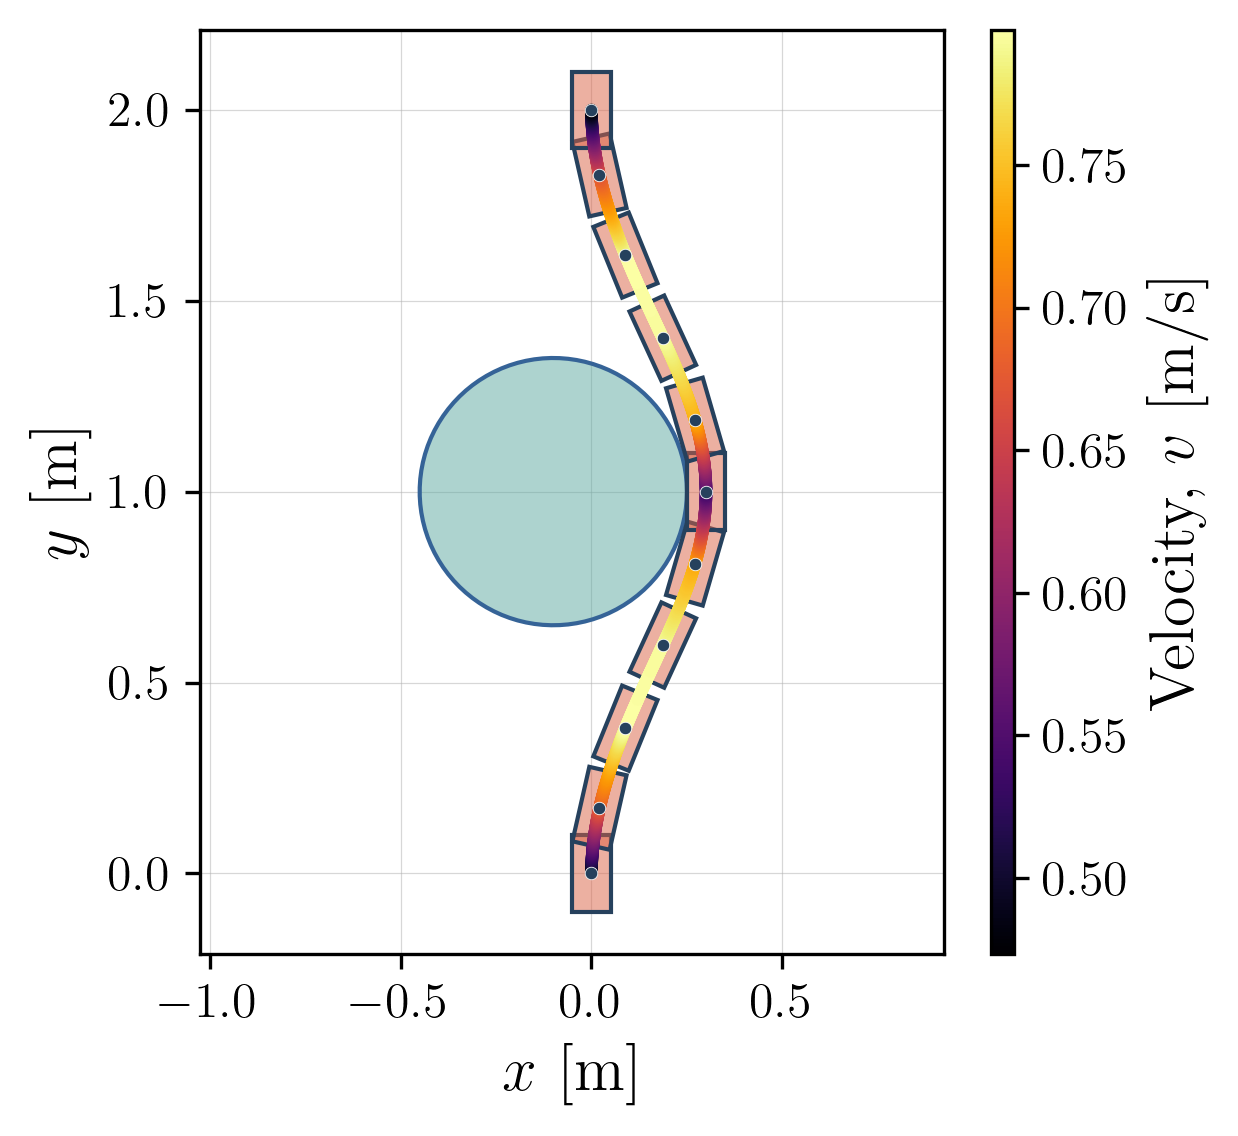

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/danylo/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.patches.Polygon object at 0x7f0b194acd00>

In [5]:
# Trajectory plot
ctres, overlap = 1000, 3
N = size(sol.xd, 2)
xct = hcat([sample(sol.xc, t) for t in LinRange(0, 1, ctres)]...)
vct = vcat([sample(sol.uc, t)[1] for t in LinRange(0, 1, ctres)]...)
cmap = generate_colormap("inferno"; minval=minimum(vct), maxval=maximum(vct))

# plot_options = Dict("xtick.labelsize"=>9,
#                     "ytick.labelsize"=>9,
#                     "axes.labelsize"=>11)
# fig = create_figure((4, 4); options = plot_options)

fig = plt.figure(figsize=(4,4), dpi=300)
plt.clf()
set_fonts()
set_fonts()

ax = setup_axis!(111, xlabel="\$x\$ [m]", ylabel="\$y\$ [m]",
                 axis="equal", cbar=cmap, clabel="Velocity, \$v\$ [m/s]",
                 cbar_aspect=40)
ax.plot(sol.xd[1, :], sol.xd[2, :],
        linestyle="none", marker="o", markerfacecolor=DarkBlue,
        markeredgecolor="white", markeredgewidth=0.2, markersize=3,
        zorder=20)
line_segs = Vector{Matrix}(undef, 0)
line_clrs = Vector{NTuple{4, Real}}(undef, 0)
for k=1:ctres-overlap
    push!(line_segs, xct[1:2, k:k+overlap]')
    push!(line_clrs, cmap.to_rgba(vct[k]))
end
trajectory = PyPlot.matplotlib.collections.LineCollection(
    line_segs, zorder=10, colors = line_clrs, linewidths=3,
    capstyle="round")
ax.add_collection(trajectory)
Rect = PyPlot.matplotlib.patches.Rectangle
for k=1:N
    local xl, xw = [1;1;-1;-1;1]*_carl/2, [1;-1;-1;1;1]*_carw/2
    local yl, yw = [1;1;-1;-1;1]*_carl/2, [-1;1;1;-1;-1]*_carw/2
    local ang = sol.xd[3,k]
    local xc = sol.xd[1,k].+xl.*sin(ang).+xw.*cos(ang)
    local yc = sol.xd[2,k].+yl.*cos(ang).+yw.*sin(ang)
    ax.fill(xc, yc,
            linewidth=1,
            edgecolor=DarkBlue,
            facecolor=rgb2pyplot(parse(RGB, Red), a=0.5),
            zorder=6)
end
ang = LinRange(0, 2*pi, 100)
obs = ([cos.(ang)'; sin.(ang)']*_ro).+_co
ax.fill(obs[1, :], obs[2, :],
        linewidth=1,
        edgecolor=Blue,
        facecolor=rgb2pyplot(parse(RGB, Green), a=0.5),
        zorder=5)
# save_figure("../figures/dubin_trajectory.pdf")